## National Institute for Space Research
   <img src="img/icone_cap394.svg" align="right" alt="Drawing" style="width: 200px;"/>
   
#### Project for course  Introduction to Data Science - CAP 394
#### Student: 
* Helvecio Bezerra Leal Neto

#### Instructors: 
* Dr. Gilberto Queiroz 
* Dr. Rafael Santos

## Schedule
     - [x] Data reading
     - [x] Data visualization
     - [x] Cluster detection algorithm
     - [x] Preprocessing
     - [ ] Final analysis and project elaboration

### Index

  [About](#about) <br></br>
  [The Data](#the_data)<br></br>
  [Reading Data](#reading_data)<br></br>

<a id='about'></a>
## About

This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis on Radar data by surveying the raw data, processing them and understanding the dynamics of cloud movement in the study region. At the end of the exploratory process it will be possible to estimate the behavior of the clouds in relation to their movement, making an algorithm capable of estimating the movement from two consecutive images.

<a id='the_data'></a>
## The Data

The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals.

https://www.arm.gov/research/campaigns/amf2014goamazon

<a id='reading_data'></a>
## Reading Data

#### 1.1 - Libraries used

In [1]:
import datetime
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
from matplotlib import animation
from matplotlib import markers
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#%matplotlib
%matplotlib inline

#### 1.2 Openning dataset

In [2]:
day = 20140923

#read first file to extract static variable values
path = 'data/radar/'
first_file = path+str(day)+'/'+str(os.listdir(path+str(day))[0])
    
xds = xr.open_dataset(first_file)

rr = xds.rain_rate                  ### Matrix with preciptation values
runit = xds.rain_rate.units         ### Unit of rain_rate mm/h
rkm = xds.rain_rate.height_km       ### Unit of matrix dimensions km
lon = xds.lon0.data                 ### Coordinate Longitude Matrix
lat = xds.lat0.data                 ### Corrdinate Latitude Matrix
x0 = xds.x0                         ### Matrix of points
y0 = xds.y0

In [3]:
xds

<xarray.Dataset>
Dimensions:     (x0: 241, y0: 241)
Dimensions without coordinates: x0, y0
Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 -5.3025093 -5.302555 ... -0.99165195 -0.9916234
    lon0        (y0, x0) float32 -62.156715 -62.138676 ... -57.854195 -57.83623
    rain_rate   (y0, x0) float32 ...
Attributes:
    description:  SIPAM Manaus S-Band Gridded Rain Rates
    source:       SIPAM Manaus S-Band Radar
    institution:  SIPAM/Texas A&M University
    comment:      v2.0a; Created at Texas A&M University (cschu@tamu.edu)
    references:   http://atmo.tamu.edu/goamazon-sband-radar
    created:      Wed Sep  6 19:39:02 2017\n

#### 1.3 Variables present in the dataset

In [4]:
xds.data_vars

Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 -5.3025093 -5.302555 ... -0.99165195 -0.9916234
    lon0        (y0, x0) float32 -62.156715 -62.138676 ... -57.854195 -57.83623
    rain_rate   (y0, x0) float32 ...

#### 1.4 Attributes from dataset

In [5]:
xds.attrs

OrderedDict([('description', 'SIPAM Manaus S-Band Gridded Rain Rates'),
             ('source', 'SIPAM Manaus S-Band Radar'),
             ('institution', 'SIPAM/Texas A&M University'),
             ('comment',
              'v2.0a; Created at Texas A&M University (cschu@tamu.edu)'),
             ('references', 'http://atmo.tamu.edu/goamazon-sband-radar'),
             ('created', 'Wed Sep  6 19:39:02 2017\n')])

#### 1.5 Read all data

In [6]:
def readData(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # pixel size (in meters)
    dx = 1000.
    dy = 1000.

    downsizeby = 1    

    # Compute grid dimensions and grid coordinates after resampling
    dx2, dy2 = dx*downsizeby, dy*downsizeby
    nx2, ny2 = int(nx/downsizeby), int(ny/downsizeby)

    X2, Y2 = np.meshgrid( np.arange(0,nx2*dx2, dx2), np.arange(0,ny2*dy2, dy2) )

    # Define container
    frames = np.zeros( (interval, nx2, ny2 ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

In [7]:
frames = readData(day)
print('The frames from dataset:data (times,x,y) -> ',frames.shape)

The frames from dataset:data (times,x,y) ->  (120, 241, 241)


#### 1.6 Plot simple example without colormap legends for Time Zero

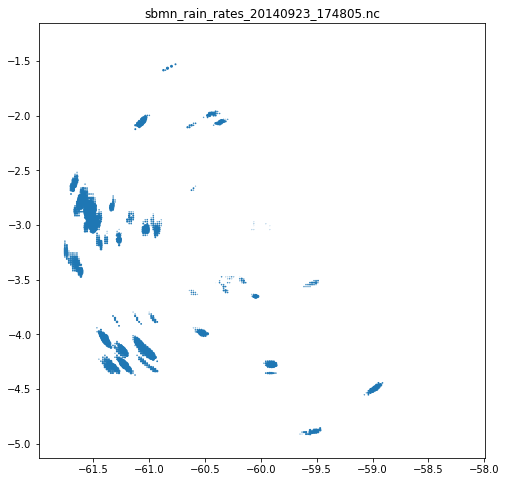

In [8]:
## Plot simple figure from dataset

figtime = 89

filename = sorted(os.listdir(path+str(day)))[figtime]

plt.figure(figsize=(8,8))
plt.title(filename)
plt.scatter(lon,lat,frames[figtime])
#plt.pcolormesh(lon,lat,frames[figtime])

#### 1.7 Clusterization

In [9]:
def clust(time1):    #11.53:
    
    dx ,dy = [],[]
    te = None
    
    for i in range(241):
        for j in range(241):
            if not np.isnan(time1[i][j]) and time1[i][j] > 21.8:
                dx.append(i)
                dy.append(j)

    dim = len(dx)
    
    # Check dimension
    if dim > 4:   
        for x in range(dim):
            dx.append(np.float32('nan'))
            dy.append(np.float32('nan'))

        matrix = np.ndarray(shape=(dim, 2), dtype='float32')
        pt = pd.DataFrame(columns=['x1','y1'])
    
        for x in range(dim):
            matrix[x] = (dx[x], dy[x])
            pt['x1'] = matrix[:,0]
            pt['y1'] = matrix[:,1]
        
        te = pt[['x1','y1']]
          
        #bandwidth = estimate_bandwidth(te, quantile=0.3)
        ms = MeanShift(bandwidth=5, bin_seeding=True, cluster_all=True, min_bin_freq=1,
         n_jobs=None, seeds=None)

        ms.fit(te)
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_
        n_clusters_ = len(np.unique(labels))
        
#     colors = 10*['r.','g.','b.','c.','k.','y.','m.']
#     for i in range(len(te)):
#            #print(te['x1'][i])
#         plt.plot(te['x1'][i], te['y1'][i], colors[labels[i]], markersize = 10)
#         plt.title('Estimated number of clusters: %d' % n_clusters_)

# #         kmeans = KMeans().fit(te)
# #         labels = kmeans.labels_
# #         cluster_centers = kmeans.cluster_centers_
# #         n_clusters_ = len(np.unique(labels))

        te['cluster']=labels
    
    return te

In [348]:
data = readData(day)
clusters = clust(data[104])
clusters.head()

,x1,y1,cluster
0,25.0,100.0,2
1,25.0,101.0,2
2,25.0,102.0,2
3,25.0,103.0,2
4,26.0,98.0,2


In [349]:
def createData(time,clusters):
    
    if isinstance(clusters,pd.DataFrame):
        
        ##Static Radar Coordinates Value for Topological relation
        radar = (-3.148556, -59.992000)

        FAM1 = pd.DataFrame(columns=['YEAR','MONTH','DAY','HOUR','MINUTE',
                                     'N_Cluster','ID_CLUS','LAT','LON','IND_X','IND_Y',
                                     'T_RELATION','RAIN_FALL','DBz'])

        LAT_ = (lat[clusters['x1'].astype(int),clusters['y1'].astype(int)])
        LON_ = (lon[clusters['x1'].astype(int),clusters['y1'].astype(int)])
        N_CLUST = len(clusters['cluster'].unique())

        rfall = []
        rlation = []
        
        for i,row in clusters.iterrows():
            x_1, x_2 = row['x1'].astype(int), row['y1'].astype(int)
            rfall.append(frames[time][x_1][x_2])
            r = tRelation((LAT_[i],LON_[i]),radar)   ### Topological Relation
            rlation.append(r)

        FAM1['IND_X'], FAM1['IND_Y'] = clusters['x1'],clusters['y1']
        FAM1['LAT'],FAM1['LON'] = LAT_,LON_
        FAM1['N_Cluster'] = N_CLUST
        FAM1['ID_CLUS'] = clusters['cluster']
        FAM1['RAIN_FALL'] = rfall
        FAM1['T_RELATION'] = rlation
        FAM1['DBz'] =  10 * np.log10(200*FAM1['RAIN_FALL']**1.6)           ### Reflectivity = 10*log10(200R1.6)
        FAM1['YEAR'] = str(sorted(os.listdir(path+str(day)))[time])[16:20]
        FAM1['MONTH'] = str(sorted(os.listdir(path+str(day)))[time])[20:22]
        FAM1['DAY'] = str(sorted(os.listdir(path+str(day)))[time])[22:24]
        FAM1['HOUR'] = str(sorted(os.listdir(path+str(day)))[time])[25:27]
        FAM1['MINUTE'] = str(sorted(os.listdir(path+str(day)))[time])[27:29]
        
    else:
        return None

    return FAM1

In [350]:
data = readData(day)
clusterizado = clust(data[104])
createData(104,clusterizado).head()

,YEAR,MONTH,DAY,HOUR,MINUTE,N_Cluster,ID_CLUS,LAT,LON,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
0,2014,09,23,20,48,6,2,-4.856026,-60.352570,25.0,100.0,SW,35.410336,47.796381
1,2014,09,23,20,48,6,2,-4.856033,-60.334541,25.0,101.0,SW,45.014862,49.463995
2,2014,09,23,20,48,6,2,-4.856040,-60.316509,25.0,102.0,SW,28.273729,46.232429
3,2014,09,23,20,48,6,2,-4.856046,-60.298481,25.0,103.0,SW,22.906746,44.769714
4,2014,09,23,20,48,6,2,-4.838044,-60.388615,26.0,98.0,SW,47.659370,49.860673


In [351]:
def centroidData(clus):
    
    if isinstance(clus,pd.DataFrame):
        centroid = pd.DataFrame()
        for i in range(clus['N_Cluster'].max()):
            ct = clus.loc[clus['ID_CLUS'] == i ]
            ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid = centroid.append(ct)
    else:
        return None
    return centroid

In [352]:
frameTime = 104

pdCenter = clust(data[104])
pdCenter = createData(frameTime,pdCenter)
centroidData(pdCenter)

,YEAR,MONTH,DAY,HOUR,MINUTE,N_Cluster,ID_CLUS,LAT,LON,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
39,2014,09,23,20,48,6,0,-1.945103,-61.034569,187.0,62.0,NW,119.267403,56.234648
19,2014,09,23,20,48,6,1,-3.849518,-60.946346,81.0,67.0,SW,36.488811,48.004855
5,2014,09,23,20,48,6,2,-4.838052,-60.370586,26.0,99.0,SW,55.177624,50.878508
13,2014,09,23,20,48,6,3,-4.442606,-60.694740,48.0,81.0,SW,32.764000,47.256651
16,2014,09,23,20,48,6,4,-3.885595,-60.784317,79.0,76.0,SW,36.728539,48.050358
8,2014,09,23,20,48,6,5,-4.802001,-59.397106,28.0,153.0,SE,24.935989,45.359526


In [287]:
def tRelation(p,q):

    north_west       =  p[1] <  q[1] and  p[0] >  q[0] 
    restricted_north =  p[1] == q[1] and  p[0] >  q[0]
    north_east       =  p[1] >  q[1] and  p[0] >  q[0]
    restricted_west  =  p[1] <  q[1] and  p[0] == q[0]
    same_position    =  p[1] == q[1] and  p[0] == q[0]
    restricted_east  =  p[1] >  q[1] and  p[0] == q[0]
    south_west       =  p[1] <  q[1] and  p[0] <  q[0]
    restricted_south =  p[1] == q[1] and  p[0] <  q[0] 
    south_est        =  p[1] >  q[1] and  p[0] <  q[0]

    if north_west == True:
        return ('NW')
    if restricted_north == True:
        return ('RN')
    if north_east == True:
        return ('NE')
    if restricted_west == True:
        return ('RW')
    if same_position == True:
        return('SP')
    if restricted_east == True:
        return ('RE')
    if south_west == True:
        return ('SW')
    if restricted_south == True:
        return ('RS')
    if south_est == True:
        return ('SE')

#### 1.8 Pre-processing

In [15]:
def run():
    data = readData(day)    
    total = []
    
    dados = pd.DataFrame()
    
    for i in range(len(data)):
        cluster = clust(data[i])
             
        if isinstance(cluster,pd.DataFrame):
            clt = createData(i,cluster)
            clt2 = centroidData(clt)
            dados = dados.append(clt2)
        else:
            pass
            
    dados.to_csv('output/Moderate_Centroid_OUTPUT_'+str(sorted(os.listdir(path+str(day)))[i][:-3])+'.csv')

### RUN PROCESS

In [16]:
run()

In [341]:
#### SETUP FOR PLOT

def setupMap(frame):

    time = frame

    centroid = []
    centers = clust(data[time])

    if isinstance(centers,pd.DataFrame):

        centers = createData(time,centers)
        c_lat = centers['LAT']
        c_lon = centers['LON']


        ## Set centroid of clusters by MAX RAIN_FALL Rate
        for i in range(centers['N_Cluster'].max()):
            ct = centers.loc[centers['ID_CLUS'] == i ]
            ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid.append(ct)

    file = path+str(day)+'/'+str(sorted(os.listdir(path+str(day)))[time])
    xds = xr.open_dataset(file)
    date_time = xds.start_time.data
    date_time = pd.to_datetime(date_time)
    
    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = 2.2                        ## ZOOM SCALE

    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
    label = 'Rain rate in ' + runit+ ''
    title = 'SIPAM Manaus S-Band Radar :' + str(date_time)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

    cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

    ## PRECIPTACAO
    xi, yi = m(lon, lat)
    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')


    for cent in range(len(centroid)):
        clat, clon, mm_f = centroid[cent]['LAT'].item(),centroid[cent]['LON'].item(),centroid[cent]['RAIN_FALL'].item()
        #clat, clon, mm_f = centroid[1]['LAT'].item(),centroid[1]['LON'].item(),centroid[1]['RAIN_FALL'].item()
        t3x,t3y = m(clon, clat)
        m.plot(t3x,t3y, marker=markers.CARETDOWN, markersize=10, color='k')
        print(cent, clon, clat)
        #plt.annotate(str(mm_f)[0:5]+'mm/h', xy=(t3x,t3y),xytext=(t3x+12,t3y+12),rotation=45, size=10)

    m.plot(xm,ym, label='Nº Clusters: ' +str(len(centroid)),marker=markers.CARETDOWN, color='k')

    cs = m.pcolormesh(xi,yi,frames[time], cmap = cmap, norm = norm, ax=ax)

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
    m.drawmapboundary(fill_color='gray')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    #m.fillcontinents(color='#FAFAFA',lake_color='dodgerblue')
    #m.drawlsmask(land_color='Linen', lake_color='#CCFFFF')
    m.drawrivers(color = '#0043CB', linewidth=1)

    #m.readshapefile('./data/am_municipios/13MUE250GC_SIR', 'teste')
    # # # # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(label)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40)
    plt.xlabel('Latitude', labelpad=60)

    plt.savefig('radar_image/'+ sorted(os.listdir(path+str(day)))[time]+'.png')

    plt.show()

In [343]:
x1,y1 = -1.9451030492782593,-61.034568786621094      #-61.034568786621094 -1.9451030492782593
r1,r2 = -3.148556, -59.992000                  # RADAR
p = (x1,y1)                                    #PONTO
q = (r1,r2)                                    #RADAR

north_west       =  p[1] <  q[1] and  p[0] >  q[0] 
restricted_north =  p[1] == q[1] and  p[0] >  q[0]
north_east       =  p[1] >  q[1] and  p[0] >  q[0]
restricted_west  =  p[1] <  q[1] and  p[0] == q[0]
same_position    =  p[1] == q[1] and  p[0] == q[0]
restricted_east  =  p[1] >  q[1] and  p[0] == q[0]
south_west       =  p[1] <  q[1] and  p[0] <  q[0]
restricted_south =  p[1] == q[1] and  p[0] <  q[0] 
south_est        =  p[1] >  q[1] and  p[0] <  q[0]

print('NW',north_west)
print('RN',restricted_north)
print('NE',north_east)
print('RW',restricted_west)
print('SP',same_position)
print('RE',restricted_east)
print('SW',south_west)
print('RS',restricted_south)
print('SE',south_est)

NW True
RN False
NE False
RW False
SP False
RE False
SW False
RS False
SE False


0 -61.14240646362305 -1.9270390272140503
1 -60.89237976074219 -3.90346622467041
2 -60.37058639526367 -4.838052272796631
3 -59.68618392944336 -2.897728204727173


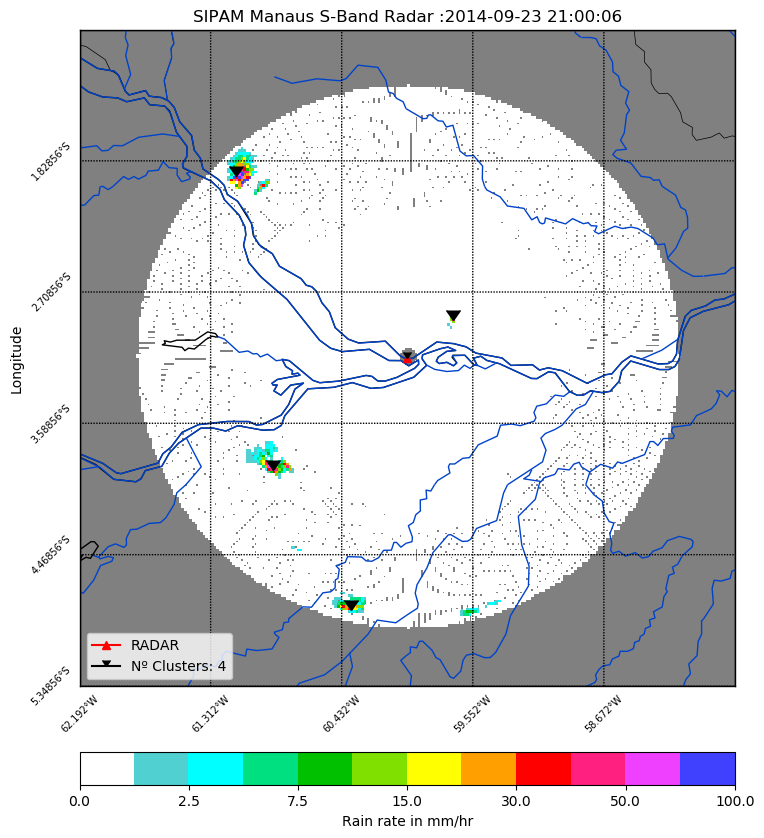

In [345]:
setupMap(105)

In [185]:
setupMap(102)

lat_RADAR:  -3.148556 lon_RADAR:  -59.992
lat_PONTO:  0    -4.909938
1    -4.909951
2    -4.891972
3    -4.873968
4    -4.802077
5    -4.802067
6    -4.784091
7    -4.784081
8    -4.730059
9    -3.849586
10   -3.849602
11   -3.831587
12   -3.831604
13   -3.831620
14   -3.831637
15   -3.813605
16   -3.813622
17   -3.813638
18   -3.813655
19   -3.795639
20   -3.795656
21   -3.795673
22   -3.777691
23   -3.777815
24   -3.759835
25   -2.340041
26   -2.322097
27   -2.304132
28   -1.927184
29   -1.909233
30   -1.891191
31   -1.873242
32   -1.873257
33   -1.855292
34   -1.855307
35   -1.837342
Name: LAT, dtype: float32 lon_PONTO:  0    -60.316536
1    -60.280476
2    -60.316525
3    -59.577339
4    -59.523296
5    -59.505268
6    -59.487255
7    -59.469227
8    -60.694992
9    -60.874317
10   -60.856312
11   -60.910313
12   -60.892307
13   -60.874302
14   -60.856297
15   -60.928303
16   -60.910294
17   -60.892288
18   -60.874283
19   -60.928284
20   -60.910278
21   -60.892273
22   -60.910259


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
def run():
    data = readData(day)    
    total = []
    
    dados = pd.DataFrame()
    
    for i in range(len(data)):
        cluster = clust(data[i])
             
        if isinstance(cluster,pd.DataFrame):
            clt = createData(i,cluster)
            clt2 = centroidData(clt)
            dados = dados.append(clt2)
        else:
            pass
            

#### 1.7 Tracking

In [ ]:
time1 = pd.read_csv('output/Moderate_Centroid_OUTPUT_sbmn_rain_rates_20140103_142413.csv')
#time1 = time1.sort_values(['IND_X', 'IND_Y'], ascending=[1,1])
time1

In [ ]:
time2 = pd.read_csv('output/Moderate_Centroid_OUTPUT_sbmn_rain_rates_20140103_143613.csv')
#time2 = time2.sort_values(['IND_X', 'IND_Y'], ascending=[1,1])
time2

In [ ]:
time3 = pd.read_csv('output/Moderate_Centroid_OUTPUT_sbmn_rain_rates_20140103_144811.csv')
time3 = time3.sort_values(['IND_X', 'IND_Y'], ascending=[1,1])
time3

In [ ]:
import cv2

In [ ]:
def optical_flow(t1,t2):

    nx = 241
    ny = 241
    empty = np.zeros(( nx,ny))

    X2, Y2 = np.meshgrid( 241, 241)
    
    for i in time1['IND_X'].astype(int):
        for j in time1['IND_Y'].astype(int):
            empty[i][j] = 1
            
    for i in time2['IND_X'].astype(int):
        for j in time2['IND_Y'].astype(int):
            empty[i][j] = 1
            
    plt.scatter(X2,Y2, empty)

    
    return empty

In [ ]:
vazio = optical_flow(time1,time2)

vazio[47][165]

In [ ]:
def tracking(t1,t2):
    
    ts = pd.concat( [t1['IND_X'],t1['IND_Y'],t2['IND_X'],t2['IND_Y']], axis=1, sort=True)
    ts.columns = ['x1','y1','x2','y2']
    
    ts = ts.fillna(0)

    
    ts = ts.sort_values(['x1'], ascending=[1])
    #ts = ts.sort_values(['y1'], ascending=[0])
    #ts = ts.sort_values(['x2'], ascending=[0])
    #ts = ts.sort_values(['y2'], ascending=[0])
    
    return ts

In [ ]:
tracking(time1,time2)

In [ ]:
plt.scatter(vazio)

In [ ]:
frame[47][167]

In [ ]:
plt.scatter(time1['IND_Y'],time1['IND_X'])

In [ ]:
plt.scatter(time2['IND_Y'],time2['IND_X'])

In [ ]:
plt.scatter(time3['IND_Y'],time2['IND_X'])

In [ ]:
from scipy import signal

def optical_flow()

#### 1.8 Statistics

#### 1.8 Function for create Animation (Giff File in root dir)

In [ ]:
def createGiff():
    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = 2.2                        ## ZOOM SCALE

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

    cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    label = 'Rain rate in ' + runit
    title = os.listdir(datadir+str(ddate))[0]


    ## BASEMAP
    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
            my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
    m.drawmapboundary(fill_color='gray')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawrivers(color = '#0043CB', linewidth=1)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40)
    plt.xlabel('Latitude', labelpad=60)

    #CLOUDS
    xi, yi = m(lon, lat)
    cs = m.pcolormesh(xi,yi,frames[0],cmap = cmap, norm = norm, ax=ax)
    cs = m.pcolormesh(xi,yi,rr)

    def init():
        return cs,

    def animate(i):
        plt.title('Tempo: ' + str(i) + ' File: '+sorted(os.listdir(datadir+str(ddate)))[i])#)
        m.pcolormesh(xi,yi,frames[i],cmap = cmap, norm = norm, ax=ax)
        return cs,

    # # # # # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(label)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=interval,  blit=True, repeat=True, save_count=interval)
    anim.save(os.listdir(datadir+str(ddate))[0]+'.gif', writer='imagemagick', fps=1)

In [ ]:
def createGiff():
    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = 2.2                        ## ZOOM SCALE

    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
    label = 'Rain rate in ' + runit+ ''
    title = 'SIPAM Manaus S-Band Radar :' + str(date_time)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

    cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')


    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
    m.drawmapboundary(fill_color='gray')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawrivers(color = '#0043CB', linewidth=1)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40)
    plt.xlabel('Latitude', labelpad=60)

    #CLOUDS
    xi, yi = m(lon, lat)
    cs = m.pcolormesh(xi,yi,frames[0],cmap = cmap, norm = norm, ax=ax)
    
    for cent in range(len(centroid)):
        clat, clon, mm_f = centroid[cent]['LAT'].item(),centroid[cent]['LON'].item(),centroid[cent]['RAIN_FALL'].item()

        t3x,t3y = m(clon, clat)
        m.plot(t3x,t3y, marker=markers.CARETDOWN, markersize=10, color='k')
    
    #cs = m.pcolormesh(xi,yi,rr)

#     def init():
#         return cs,

#     def animate(i):
#         plt.title('Tempo: ' + str(i) + ' File: '+sorted(os.listdir(datadir+str(ddate)))[i])#)
#         m.pcolormesh(xi,yi,frames[i],cmap = cmap, norm = norm, ax=ax)
        
#         for cent in range(len(centroid)):
#             clat, clon, mm_f = centroid[cent]['LAT'].item(),centroid[cent]['LON'].item(),centroid[cent]['RAIN_FALL'].item()

#             t3x,t3y = m(clon, clat)
#             m.plot(t3x,t3y, marker=markers.CARETDOWN, markersize=10, color='k')
            
#         return cs,

    # # # # # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(label)

#     anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10,  blit=True, repeat=True, save_count=10)
#     anim.save('teste.gif', writer='imagemagick', fps=1)

In [ ]:
createGiff()

In [ ]:
#     clusters = []
        
#     clus = pd.DataFrame(columns = ['N_Cluster','LON','LAT','IND_X','IND_Y','PRECIPIT'])

#     for i in range(len(matrix)):
#         clus = clus.append({'N_Cluster': labels[i],
#                                'LON': lon[(int(matrix[i][0]),int(matrix[i][1]))],
#                                'LAT': lat[(int(matrix[i][0]),int(matrix[i][1]))],
#                                'IND_X': matrix[i][0],
#                                'IND_Y': matrix[i][1],
#                                'PRECIPIT': frames[time1][int(matrix[i][0])][int(matrix[i][1])]},ignore_index=True)              
    #print(n_clusters_)
    #print(cluster_centers)
    #colors = 10*['r.','g.','b.','c.','k.','y.','m.']

#     for i in range(len(pt)):
#         plt.plot(pt['x1'], pt['y1'], colors[labels[i]], markersize = 10)
                                         
        #plt.annotate(i,(cluster_centers[:,1], cluster_centers[:,0]),ha='center')

    #plt.scatter(pt['x1'],pt['y1'],c=labels)
    
    
        
#         for i in range(len(matrix2)):
#             plt.plot(matrix2[i][1], matrix2[i][0], colors[labels[i]], markersize = 10)

#     plt.title('Estimated number of clusters: %d' % n_clusters_)    
        
#     #plt.scatter(cluster_centers[:,1], cluster_centers[:,0],
#     #            marker = 'x', s=150, linewidths=10, zorder=10)
        
#      for i, txt in enumerate(range(n_clusters_)):
#             plt.annotate(txt,(cluster_centers[i,1],cluster_centers[i,0]),textcoords="offset points",xytext=(0,10),ha='center')

# #     plt.show()
        
#     return clus

In [ ]:
def tracking(t1,t2):
    
    ts = pd.concat( [t1['IND_X'],t1['IND_Y'],t2['IND_X'],t2['IND_Y']], axis=1, sort=True)
    ts.columns = ['x1','y1','x2','y2']

    
    ts = ts.sort_values(['x1', 'y1', 'x2', 'y2'], ascending=[1,1,1,1])
    
#     bandwidth = estimate_bandwidth(matrix, quantile=0.1)
#     ms = MeanShift(bandwidth=2, bin_seeding=True, cluster_all=True, min_bin_freq=1,
#          n_jobs=None, seeds=None)
    
#     #ms = MeanShift(bandwidth=2)
#     ms.fit(matrix)
#     labels = ms.labels_
#     cluster_centers = ms.cluster_centers_
#     n_clusters_ = len(np.unique(labels)) 
    
#     matrix['cluster']=labels
#     print(cluster_centers)
        
    return ts

In [ ]:
### CLUSTERING IN TWO TIMES

def clusterization(time1,time2):    
    
    dx ,dy = [],[]
    dx2 ,dy2 = [],[]
    te = None
    
    for i in range(241):
        for j in range(241):
            if not np.isnan(frames[time1][i][j]) and frames[time1][i][j] > 11.53:
                dx.append(i)
                dy.append(j)
                
    for i in range(241):
        for j in range(241):
            if not np.isnan(frames[time2][i][j]) and frames[time2][i][j] > 11.53:
                dx2.append(i)
                dy2.append(j)                

    dim = len(dx)
    dim2 = len(dx2)
    
    # Check dimension
    if dim > 4 and dim2 >4:   
    
        if dim < dim2:
            for x in range(abs(dim-dim2)):
                dx.append(np.float32('nan'))
                dy.append(np.float32('nan'))
            dim = dim2
        elif dim2 < dim:
            for x in range(abs(dim-dim2)):
                dx2.append(np.float32('nan'))
                dy2.append(np.float32('nan'))
            dim2 = dim

        matrix = np.ndarray(shape=(dim, 2), dtype='float32')
        matrix2 = np.ndarray(shape=(dim2, 2), dtype='float32')


        for x in range(dim):
            matrix[x] = (dx[x], dy[x])

        for x2 in range(dim2):
            matrix2[x2] = (dx2[x2], dy2[x2])
            

        pt = pd.DataFrame(columns=['x1','y1','x2','y2'])
        

        pt['x1'] = matrix[:,0]
        pt['y1'] = matrix[:,1]
        pt['x2'] = matrix2[:,0]
        pt['y2'] = matrix2[:,1]
        
        te = pt[['x1','y1','x2','y2']]
        te = te.fillna(0)    

        bandwidth = estimate_bandwidth(te, quantile=0.3)
        ms = MeanShift(bandwidth=bandwidth)
        ms.fit(te)
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_
        n_clusters_ = len(np.unique(labels))        

#         kmeans = KMeans().fit(te)
#         labels = kmeans.labels_
#         cluster_centers = kmeans.cluster_centers_
#         n_clusters_ = len(np.unique(labels))

        te['cluster']=labels
    
    return te

In [ ]:
day = 20140103 

def run():
    data = readData(day)
    
    for i in range(1,len(data),1):
        
        cluster = clusterization(i-1,i)

        if isinstance(cluster,pd.DataFrame):
            #print(i-1,i,len(cluster['cluster'].unique()))
            
            fam1_ = cluster.loc[cluster['x1'] != 0]
            fam2_ = cluster.loc[cluster['x2'] != 0]
            
            print('Temp: ',i-1, ' Clusters: ',len(fam1_['cluster'].unique()),
                  'Temp: ',i, ' Clusters: ',len(fam2_['cluster'].unique()))
            
            fam1_ = 0
            fam2_ = 0
            
            
            #clus = pd.DataFrame(columns = ['N_Cluster','LON','LAT','IND_X','IND_Y','PRECIPIT'])
            #print(clus)
            
            
            
        else:
            print('Temp: ',i-1, 'Clusters: 0',' Temp: ',i, 'Clusters: 0')
        #print(data)
        #print(i-1,i)

In [ ]:
run()

#### RESULTS

#### CONCLUSIONS

#### REFERENCES